In [1]:
import pickle

import numpy as np
import qutip
import qutip.control.pulseoptim as cpo
from qutip.control.optimresult import OptimResult

import interaction_constants
from qubit_system.geometry.regular_lattice_1d import RegularLattice1D
from qubit_system.geometry.regular_lattice_2d import RegularLattice2D
from qubit_system.geometry.regular_lattice_3d import RegularLattice3D
from qubit_system.qubit_system_classes import StaticQubitSystem, EvolvingQubitSystem
from qubit_system.utils.ghz_states import StandardGHZState
from qubit_system.utils.interpolation import get_hamiltonian_coeff_linear_interpolation, get_hamiltonian_coeff_interpolation

In [10]:
import matplotlib.pyplot as plt
plt.rc('text', usetex=False)
plt.rc('font', family="serif", serif="CMU Serif")

In [2]:
N_RYD = 50
C6 = interaction_constants.get_C6(N_RYD)

LATTICE_SPACING = 1.5e-6

print(f"C6: {C6:.3e}")
characteristic_V = C6 / (LATTICE_SPACING ** 6)
print(f"Characteristic V: {characteristic_V:.3e} Hz")

t = 2e-6

C6: 1.555e-26
Characteristic V: 1.365e+09 Hz


# Achieving GHZ States in Evolving Systems

In [3]:
def solve_and_print_stats(e_qs: EvolvingQubitSystem):
    import time
    start_time = time.time()
    e_qs.solve()
    print(f"Solved in {time.time() - start_time:.2f}s")

    fidelity_with_ghz = e_qs.get_fidelity_with("ghz")
    fidelity_with_ghz_asymmetric = e_qs.get_fidelity_with("ghz_antisymmetric")
    print(f"fidelity with GHZ: {fidelity_with_ghz:.4f} (with antisymmetric: {fidelity_with_ghz_asymmetric:.4f})")
    fidelity_with_ground = e_qs.get_fidelity_with("ground")
    fidelity_with_excited = e_qs.get_fidelity_with("excited")
    superposition_probability = fidelity_with_ground + fidelity_with_excited
    print(f"superposition probability: {superposition_probability:.4f} (g: {fidelity_with_ground:.4f}, e: {fidelity_with_excited:.4f})")
    e_qs.plot(with_antisymmetric_ghz=True)


In [4]:
# Normalised system for GRAPE

norm_V = C6 / (LATTICE_SPACING ** 6) / characteristic_V
norm_t = t * characteristic_V

def get_normalised_hamiltonian(N: int):
    norm_e_qs = EvolvingQubitSystem(
        N=N, V=norm_V, geometry=RegularLattice1D(),
        Omega=None,    Delta=None,
        t_list=None,
        ghz_state=None
    )
    norm_hamiltonian = norm_e_qs.get_hamiltonian()
    
    norm_H_d = norm_hamiltonian[0]  # "drift": time-independent part
    norm_H_c = [norm_hamiltonian[1][0], norm_hamiltonian[2][0]]  # "control": time-dependent parts
    return norm_H_d, norm_H_c, norm_e_qs.psi_0

def get_optimised_controls(N: int, n_ts: int) -> OptimResult:
    norm_H_d, norm_H_c, psi_0 = get_normalised_hamiltonian(N)
    target_state = StandardGHZState(N).get_state_tensor()
    
    norm_scaling = 0.5 / characteristic_V
    norm_result = cpo.optimize_pulse_unitary(
        norm_H_d, norm_H_c, 
        psi_0, target_state, 
        n_ts, norm_t,
        amp_lbound=0, amp_ubound=2e9 * norm_scaling,
        pulse_scaling=1e9 * norm_scaling, pulse_offset=1e9 * norm_scaling,
        gen_stats=True,
        alg="GRAPE",
        # optim_method="FMIN_BFGS",    
        # init_pulse_type="SINE",
        max_wall_time=15, max_iter=5000, fid_err_targ=1e-10,
        log_level=qutip.logging_utils.WARN,
    )
    return norm_result

def report_stats(result: OptimResult, N: int):
    result.stats.report()
    target_state = StandardGHZState(N).get_state_tensor()

    final_fidelity = qutip.fidelity(target_state, result.evo_full_final) ** 2
    print(f"final_fidelity: {final_fidelity:.5f}")
    
    print(f"Final gradient normal {result.grad_norm_final:.3e}")
    print(f"Terminated due to {result.termination_reason}")
    
def plot_optimresult(result: OptimResult, N: int, t: float, unnormalise_V: float = None, geometry=None):
    time = result.time
    final_Omega = np.hstack((result.final_amps[:, 0], result.final_amps[-1, 0]))
    final_Delta = np.hstack((result.final_amps[:, 1], result.final_amps[-1, 1]))
    if unnormalise_V is not None: 
        t /= unnormalise_V
        time = result.time / unnormalise_V
        final_Omega *= unnormalise_V
        final_Delta *= unnormalise_V
        
    e_qs = EvolvingQubitSystem(
        N=N, V=C6, geometry=RegularLattice1D(LATTICE_SPACING) if geometry is None else geometry,
        Omega=get_hamiltonian_coeff_interpolation(time, final_Omega, "previous"),
        Delta=get_hamiltonian_coeff_interpolation(time, final_Delta, "previous"),
        t_list=np.linspace(0, t, 300),
        ghz_state=StandardGHZState(N)
    )
    solve_and_print_stats(e_qs)


## $N = 2$


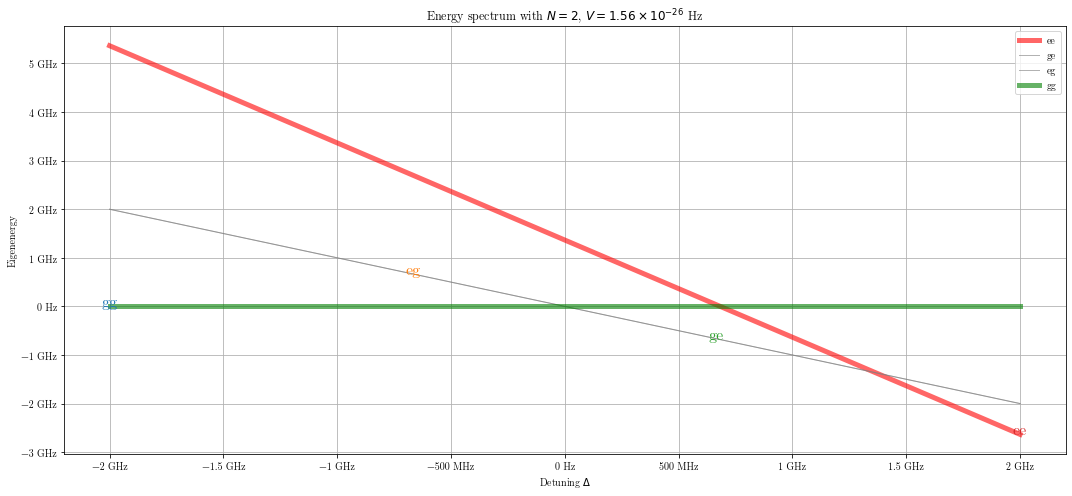

In [14]:
N = 2
s_qs_n_2 = StaticQubitSystem(
    N=N, V=C6,
    geometry=RegularLattice1D(spacing=LATTICE_SPACING),
    Omega=0, Delta=np.linspace(-2e9, 2e9, 2 ** N)
)
s_qs_n_2.plot_detuning_energy_levels(True, savefig_name="d_3_s_qs_n_2.png")

### Manual optimisation


Solved in 0.81s
fidelity with GHZ: 0.0708 (with antisymmetric: 0.9292)
superposition probability: 1.0000 (g: 0.4995, e: 0.5005)



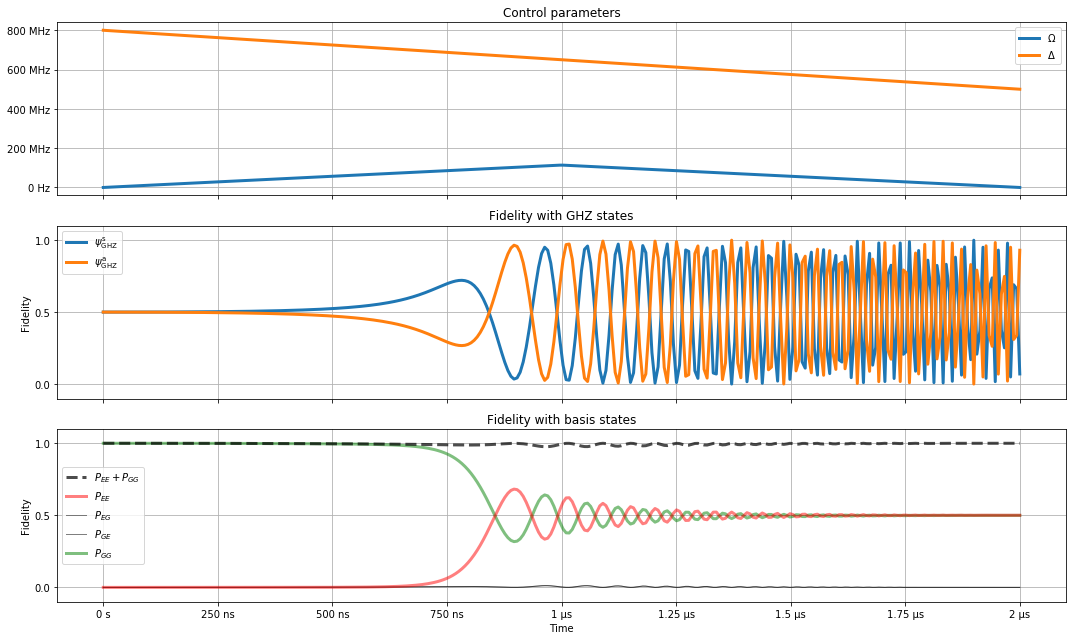

In [5]:
N = 2
e_qs = EvolvingQubitSystem(
    N=N, V=C6, geometry=RegularLattice1D(spacing=LATTICE_SPACING),
    Omega=get_hamiltonian_coeff_linear_interpolation([0, t / 2, t], [0, 114e6, 0]),
    Delta=get_hamiltonian_coeff_linear_interpolation([0, t], [800e6, 500e6]),
    t_list=np.linspace(0, t, 300),
    ghz_state=StandardGHZState(N)
)
solve_and_print_stats(e_qs)

### GRAPE



------------------------------------
---- Control optimisation stats ----
**** Timings (HH:MM:SS.US) ****
Total wall time elapsed during optimisation: 0:00:00.033145
Wall time computing Hamiltonians: 0:00:00.001448 (4.37%)
Wall time computing propagators: 0:00:00.019736 (59.54%)
Wall time computing forward propagation: 0:00:00.000301 (0.91%)
Wall time computing onward propagation: 0:00:00.000228 (0.69%)
Wall time computing gradient: 0:00:00.002445 (7.38%)

**** Iterations and function calls ****
Number of iterations: 7
Number of fidelity function calls: 14
Number of times fidelity is computed: 14
Number of gradient function calls: 13
Number of times gradients are computed: 13
Number of times timeslot evolution is recomputed: 14

**** Control amplitudes ****
Number of control amplitude updates: 13
Mean number of updates per iteration: 1.8571428571428572
Number of timeslot values changed: 130
Mean number of timeslot changes per update: 10.0
Number of amplitude values changed: 260
Mean n

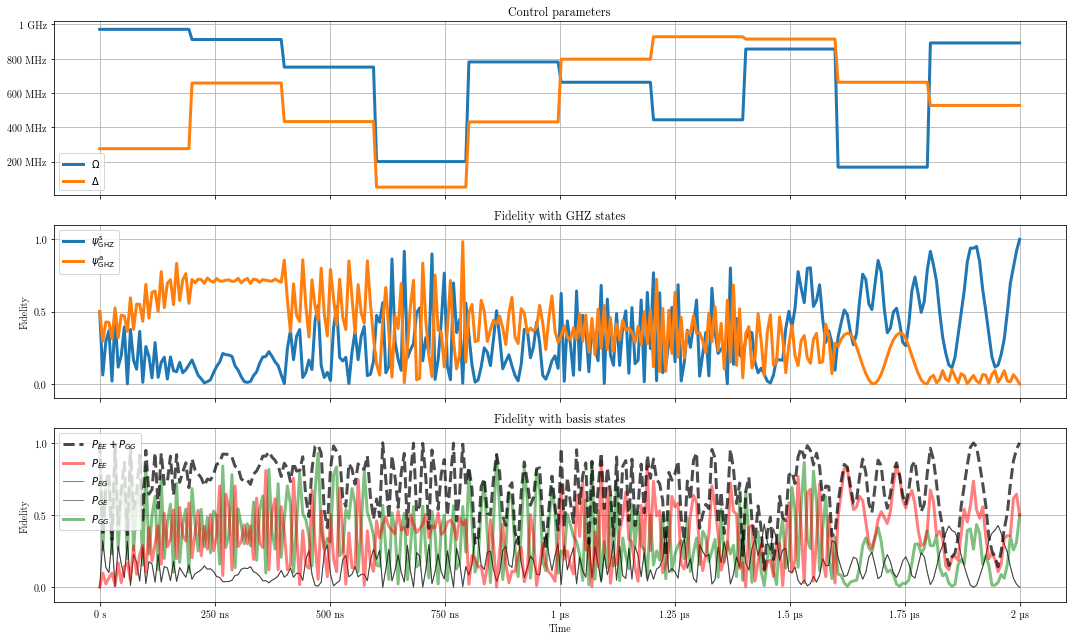

In [16]:
N = 2
optim_result = get_optimised_controls(N, n_ts=10)
report_stats(optim_result, N)
plot_optimresult(optim_result, N, norm_t, characteristic_V)

### Reinforcement learning optimisation

Solved in 0.61s
fidelity with GHZ: 0.9975 (with antisymmetric: 0.0013)
superposition probability: 0.9988 (g: 0.4810, e: 0.5177)



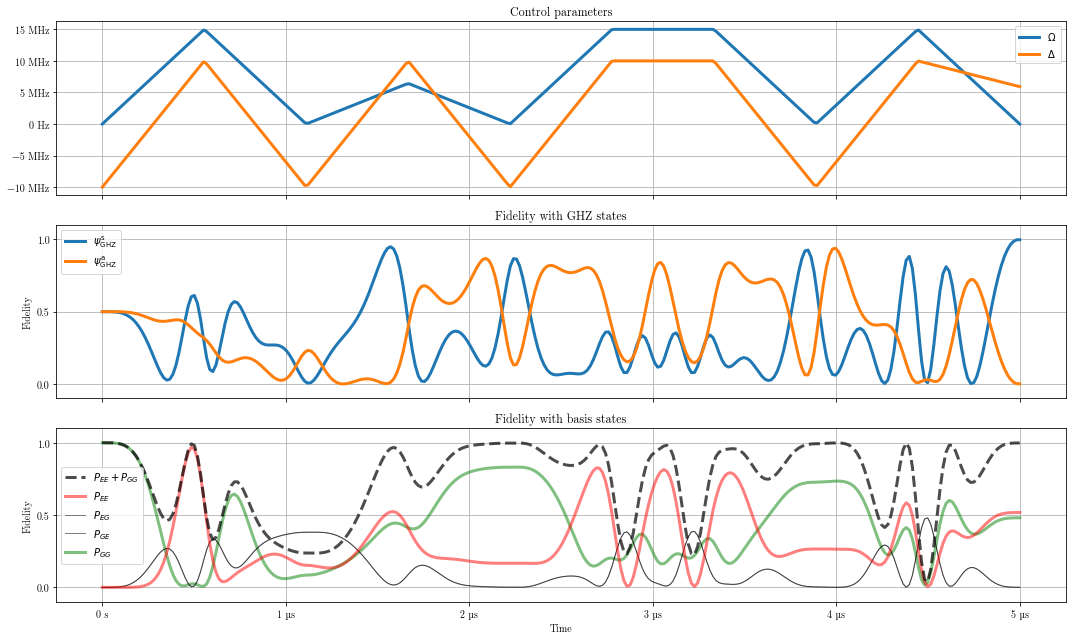

In [17]:
with open("reinforcement_learning/results/20190803_154019.pkl", "rb") as f:
    data = pickle.load(f)
    data['evolving_qubit_system_kwargs']['ghz_state'] = StandardGHZState(data['evolving_qubit_system_kwargs']['N'])  # Migrate from old saved version

t_list = data['evolving_qubit_system_kwargs']['t_list']
solve_t_list = np.linspace(t_list[0], t_list[-1], 300)
data['evolving_qubit_system_kwargs'].pop('t_list')
e_qs = EvolvingQubitSystem(
    **data['evolving_qubit_system_kwargs'],
    Omega=get_hamiltonian_coeff_linear_interpolation(
        t_list,
        data['protocol'].Omega,
    ),
    Delta=get_hamiltonian_coeff_linear_interpolation(
        t_list,
        data['protocol'].Delta,
    ),
    t_list=solve_t_list,
)
solve_and_print_stats(e_qs)

## $N = 4$

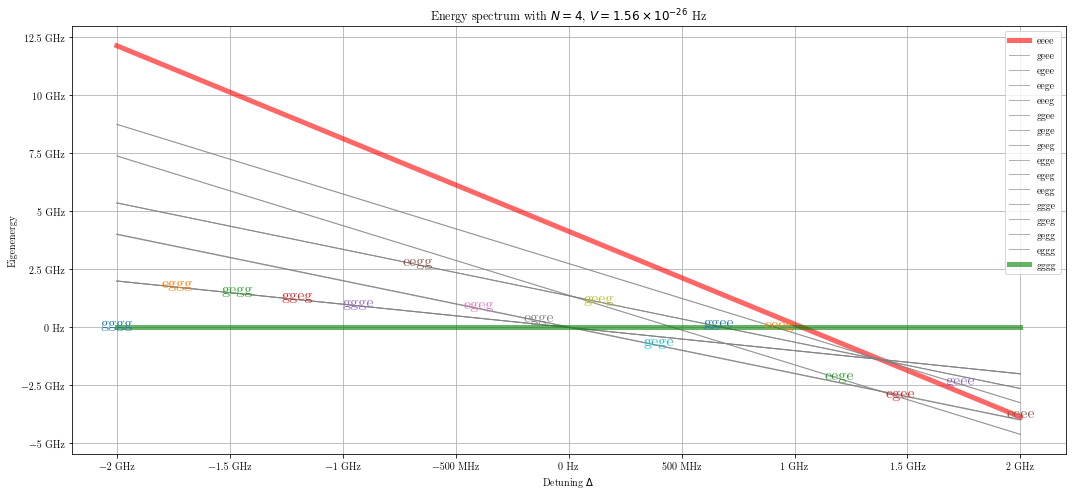

In [18]:
N = 4
s_qs_n_4 = StaticQubitSystem(
    N=N, V=C6,
    geometry=RegularLattice1D(spacing=LATTICE_SPACING),
    Omega=0, Delta=np.linspace(-2e9, 2e9, 2 ** N)
)
s_qs_n_4.plot_detuning_energy_levels(True, savefig_name="d_3_s_qs_n_4.png")

### Manual optimisation

Solved in 2.00s
fidelity with GHZ: 0.9511 (with antisymmetric: 0.0488)
superposition probability: 1.0000 (g: 0.5000, e: 0.5000)



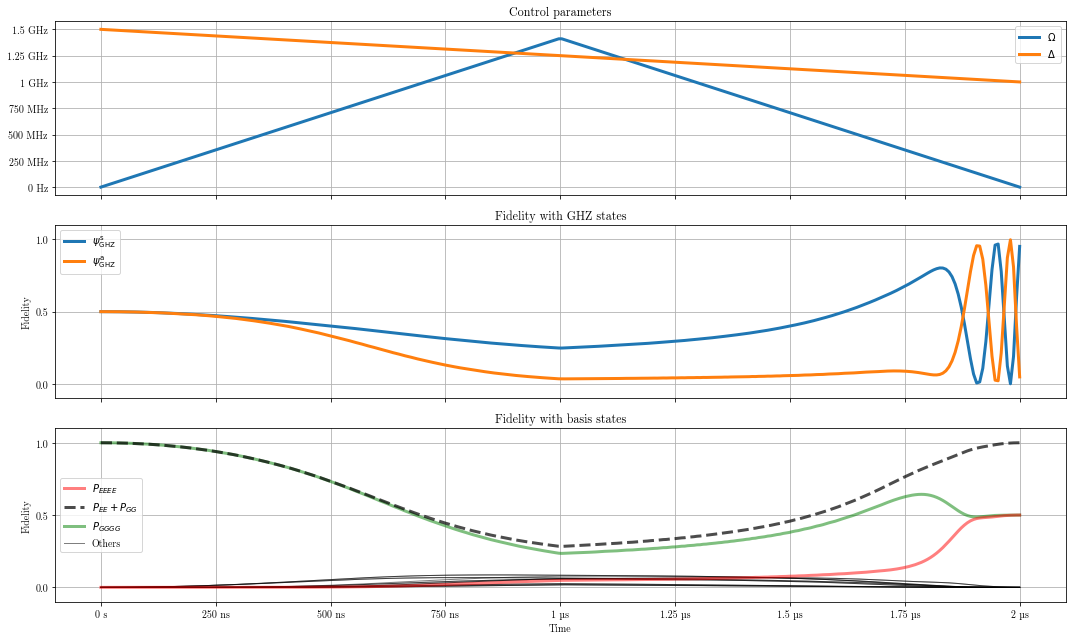

In [19]:
N = 4
e_qs = EvolvingQubitSystem(
    N=N, V=C6, geometry=RegularLattice1D(spacing=LATTICE_SPACING),
    Omega=get_hamiltonian_coeff_linear_interpolation([0, t / 2, t], [0, 1.4148e9, 0]),
    Delta=get_hamiltonian_coeff_linear_interpolation([0, t], [1.5e9, 1e9]),
    t_list=np.linspace(0, t, 300),
    ghz_state=StandardGHZState(N)
)
solve_and_print_stats(e_qs)

### GRAPE



------------------------------------
---- Control optimisation stats ----
**** Timings (HH:MM:SS.US) ****
Total wall time elapsed during optimisation: 0:00:01.295571
Wall time computing Hamiltonians: 0:00:00.068657 (5.30%)
Wall time computing propagators: 0:00:00.977047 (75.41%)
Wall time computing forward propagation: 0:00:00.012589 (0.97%)
Wall time computing onward propagation: 0:00:00.009830 (0.76%)
Wall time computing gradient: 0:00:00.087775 (6.78%)

**** Iterations and function calls ****
Number of iterations: 442
Number of fidelity function calls: 500
Number of times fidelity is computed: 500
Number of gradient function calls: 500
Number of times gradients are computed: 500
Number of times timeslot evolution is recomputed: 500

**** Control amplitudes ****
Number of control amplitude updates: 499
Mean number of updates per iteration: 1.1289592760180995
Number of timeslot values changed: 4990
Mean number of timeslot changes per update: 10.0
Number of amplitude values changed: 9

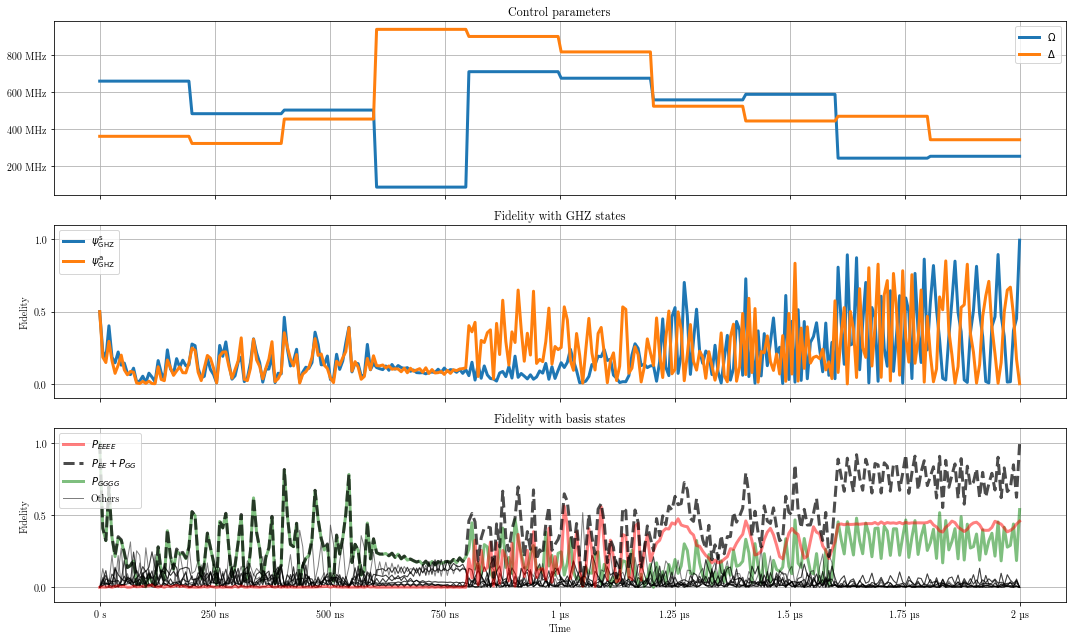

In [20]:
N = 4
optim_result = get_optimised_controls(N, n_ts=10)
report_stats(optim_result, N)
plot_optimresult(optim_result, N, norm_t, characteristic_V)


### Reinforcement learning optimisation

Solved in 3.10s
fidelity with GHZ: 0.9955 (with antisymmetric: 0.0017)
superposition probability: 0.9971 (g: 0.5326, e: 0.4646)



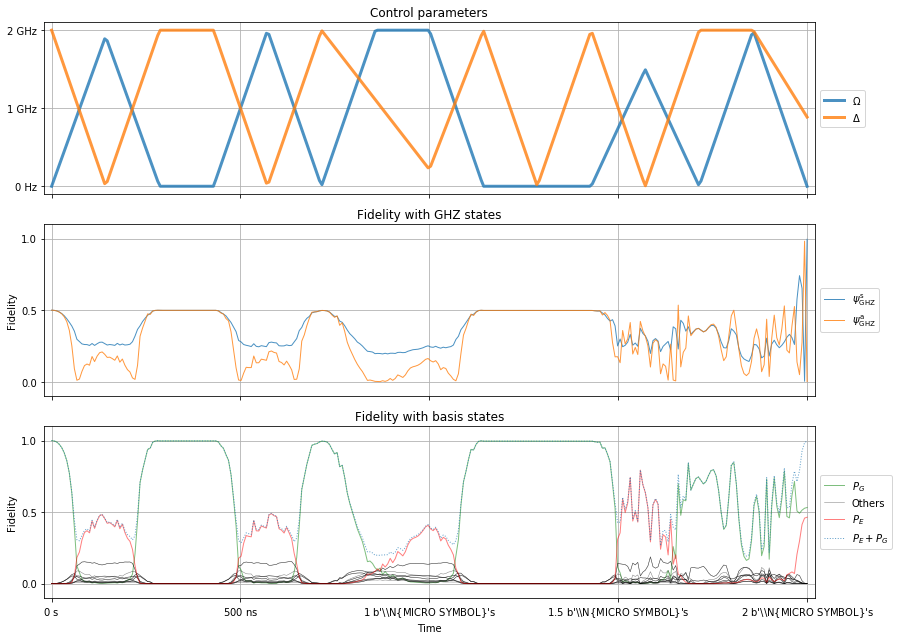

In [5]:
with open("reinforcement_learning/results/20190814_035606.pkl", "rb") as f:
    data = pickle.load(f)
    data['evolving_qubit_system_kwargs']['ghz_state'] = StandardGHZState(data['evolving_qubit_system_kwargs']['N'])  # Migrate from old saved version

t_list = data['evolving_qubit_system_kwargs']['t_list']
solve_t_list = np.linspace(t_list[0], t_list[-1], 300)

data['evolving_qubit_system_kwargs'].pop('t_list')
e_qs = EvolvingQubitSystem(
    **data['evolving_qubit_system_kwargs'],
    Omega=get_hamiltonian_coeff_linear_interpolation(
        t_list,
        data['protocol'].Omega,
    ),
    Delta=get_hamiltonian_coeff_linear_interpolation(
        t_list,
        data['protocol'].Delta,
    ),
    t_list=solve_t_list,
)
solve_and_print_stats(e_qs)

## $N = 6$

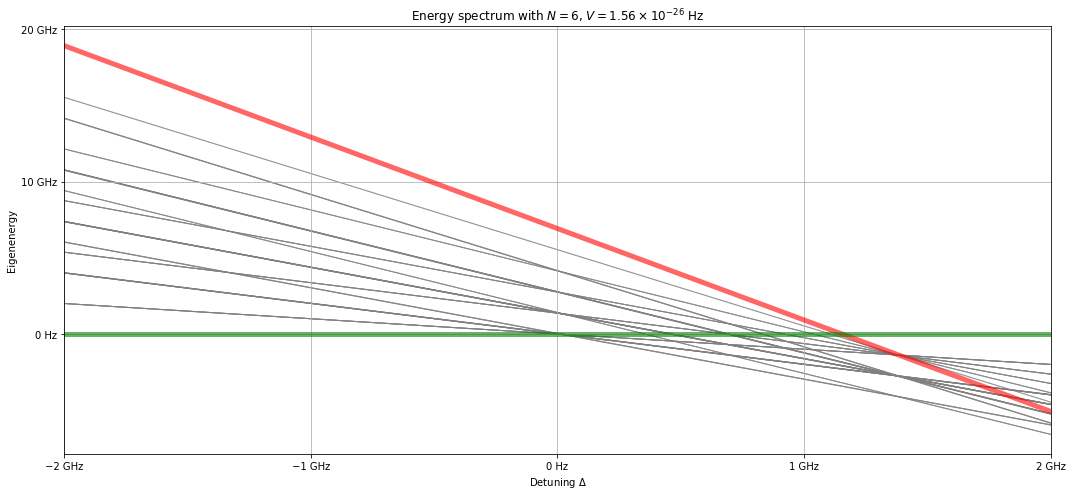

In [5]:
N = 6
s_qs_n_6 = StaticQubitSystem(
    N=N, V=C6,
    geometry=RegularLattice1D(spacing=LATTICE_SPACING),
    Omega=0, Delta=np.linspace(-2e9, 2e9, 2 ** N)
)
s_qs_n_6.plot_detuning_energy_levels(False, savefig_name="d_3_s_qs_n_6.png")

### Manual optimisation

Solved in 2.62s
fidelity with GHZ: 0.0970 (with antisymmetric: 0.9030)
superposition probability: 1.0000 (g: 0.4999, e: 0.5001)



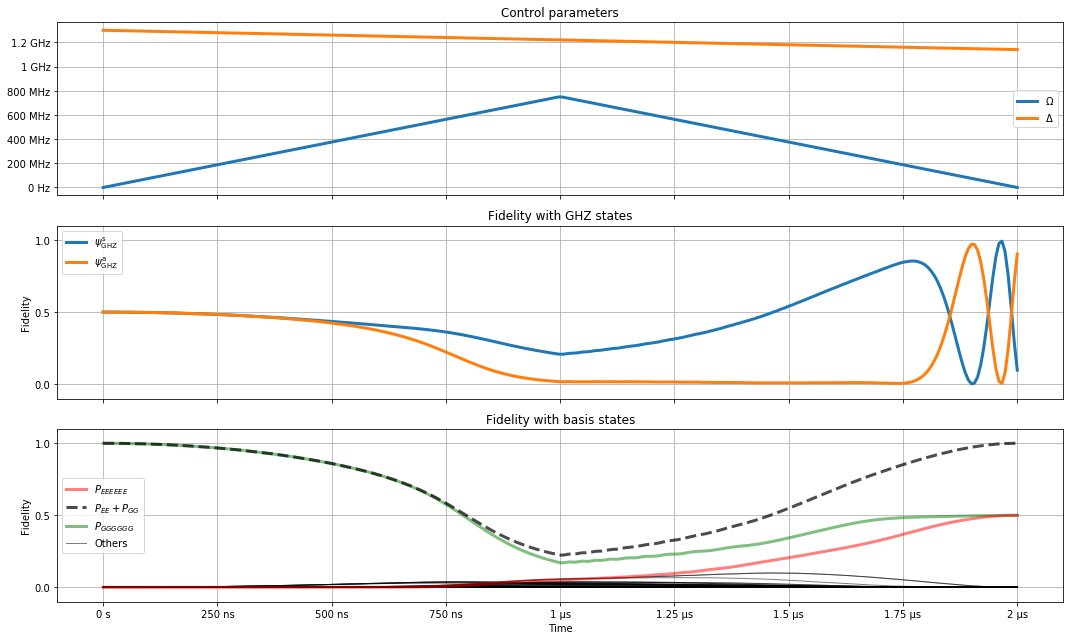

In [8]:
N = 6
e_qs = EvolvingQubitSystem(
    N=N, V=C6, geometry=RegularLattice1D(spacing=LATTICE_SPACING),
    Omega=get_hamiltonian_coeff_linear_interpolation([0, t / 2, t], [0, 751.23e6, 0]),
    Delta=get_hamiltonian_coeff_linear_interpolation([0, t], [1.3e9, 1.14e9]),
    t_list=np.linspace(0, t, 300),
    ghz_state=StandardGHZState(N)
)
solve_and_print_stats(e_qs)

### GRAPE


0.40878
0.40239
0.57661
0.45873
0.36595
0.31424
0.49889
0.50452
0.17791
0.36070
0.47029
0.44492

------------------------------------
---- Control optimisation stats ----
**** Timings (HH:MM:SS.US) ****
Total wall time elapsed during optimisation: 0:00:03.292119
Wall time computing Hamiltonians: 0:00:00.163803 (4.98%)
Wall time computing propagators: 0:00:02.893104 (87.88%)
Wall time computing forward propagation: 0:00:00.028286 (0.86%)
Wall time computing onward propagation: 0:00:00.020858 (0.63%)
Wall time computing gradient: 0:00:00.102908 (3.13%)

**** Iterations and function calls ****
Number of iterations: 189
Number of fidelity function calls: 223
Number of times fidelity is computed: 223
Number of gradient function calls: 223
Number of times gradients are computed: 223
Number of times timeslot evolution is recomputed: 223

**** Control amplitudes ****
Number of control amplitude updates: 222
Mean number of updates per iteration: 1.1746031746031746
Number of timeslot values chan

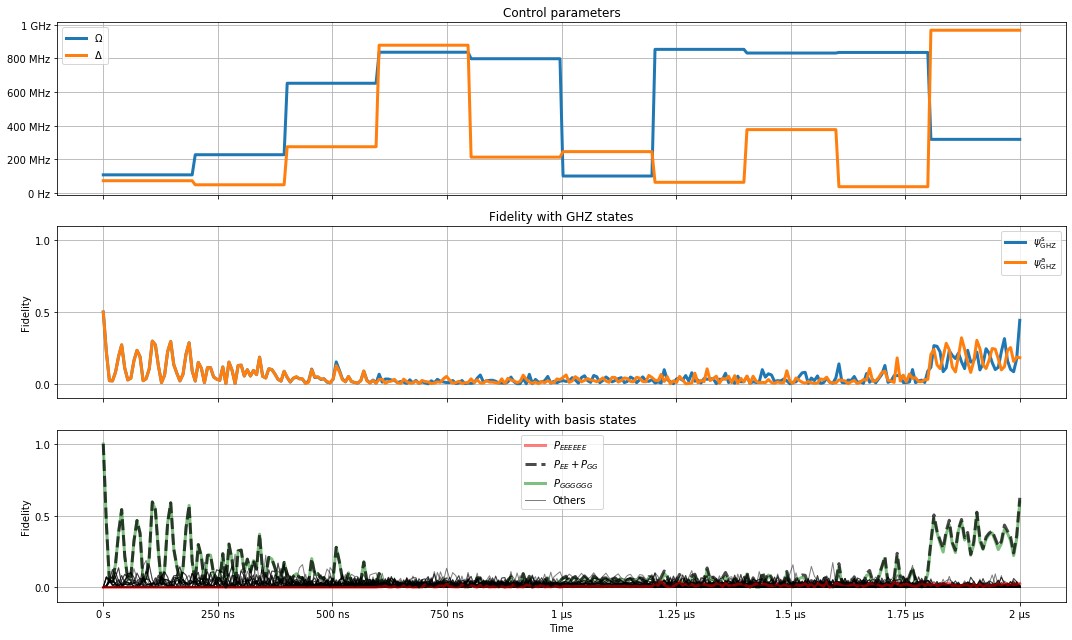

In [6]:
N = 6
target_state = StandardGHZState(N).get_state_tensor()

achieved_fidelity = 0
i = 0
while achieved_fidelity < 0.8:
    optim_result = get_optimised_controls(N, n_ts=10)
    achieved_fidelity = qutip.fidelity(target_state, optim_result.evo_full_final) ** 2
    print(f"{achieved_fidelity:.5f}")
    if i > 10:
        break
    i += 1
report_stats(optim_result, N)
plot_optimresult(optim_result, N, norm_t, characteristic_V)

## $N = 8$

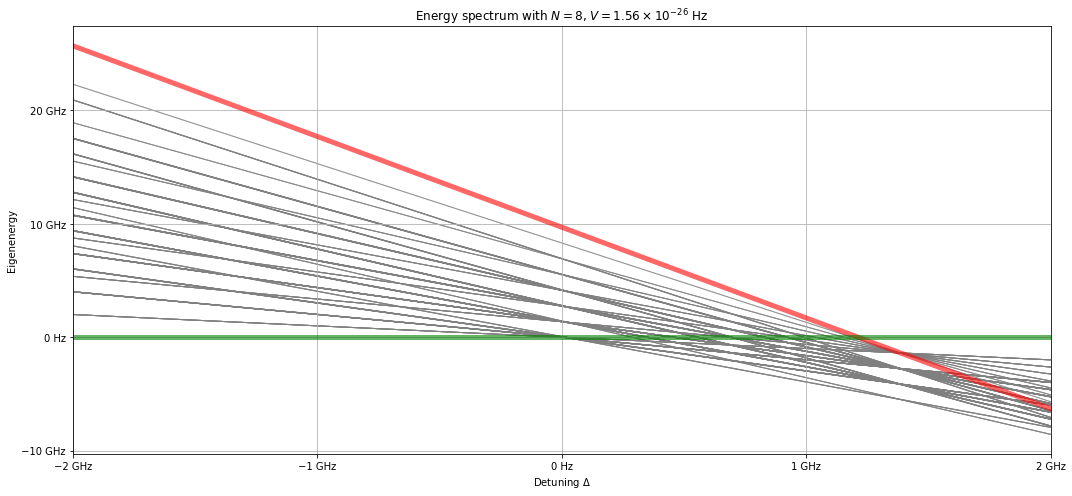

In [9]:
N = 8
s_qs_n_8 = StaticQubitSystem(
    N=N, V=C6,
    geometry=RegularLattice1D(spacing=LATTICE_SPACING),
    Omega=0, Delta=np.linspace(-2e9, 2e9, 2 ** N)
)
s_qs_n_8.plot_detuning_energy_levels(False, savefig_name="d_3_s_qs_n_8.png")

### Manual optimisation

Solved in 3.99s
fidelity with GHZ: 0.5210 (with antisymmetric: 0.4789)
superposition probability: 0.9999 (g: 0.0005, e: 0.9994)



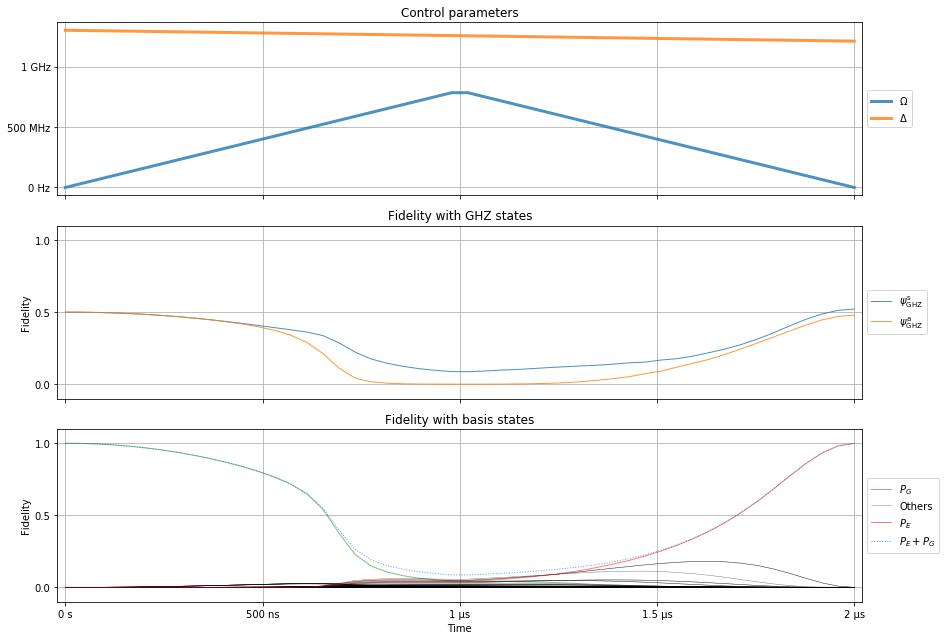

In [6]:
N = 8
e_qs = EvolvingQubitSystem(
    N=N, V=C6, geometry=RegularLattice1D(spacing=LATTICE_SPACING),
    Omega=get_hamiltonian_coeff_linear_interpolation([0, t / 2, t], [0, 800e6, 0]),
    Delta=get_hamiltonian_coeff_linear_interpolation([0, t], [1.3e9, 1.21e9]),
    t_list=np.linspace(0, t, 50),
    ghz_state=StandardGHZState(N)
)
solve_and_print_stats(e_qs)



### GRAPE



------------------------------------
---- Control optimisation stats ----
**** Timings (HH:MM:SS.US) ****
Total wall time elapsed during optimisation: 0:00:17.862020
Wall time computing Hamiltonians: 0:00:01.570685 (8.79%)
Wall time computing propagators: 0:00:16.159821 (90.47%)
Wall time computing forward propagation: 0:00:00.024967 (0.14%)
Wall time computing onward propagation: 0:00:00.023736 (0.13%)
Wall time computing gradient: 0:00:00.061821 (0.35%)

**** Iterations and function calls ****
Number of iterations: 5
Number of fidelity function calls: 18
Number of times fidelity is computed: 18
Number of gradient function calls: 18
Number of times gradients are computed: 18
Number of times timeslot evolution is recomputed: 18

**** Control amplitudes ****
Number of control amplitude updates: 17
Mean number of updates per iteration: 3.4
Number of timeslot values changed: 340
Mean number of timeslot changes per update: 20.0
Number of amplitude values changed: 680
Mean number of amplit

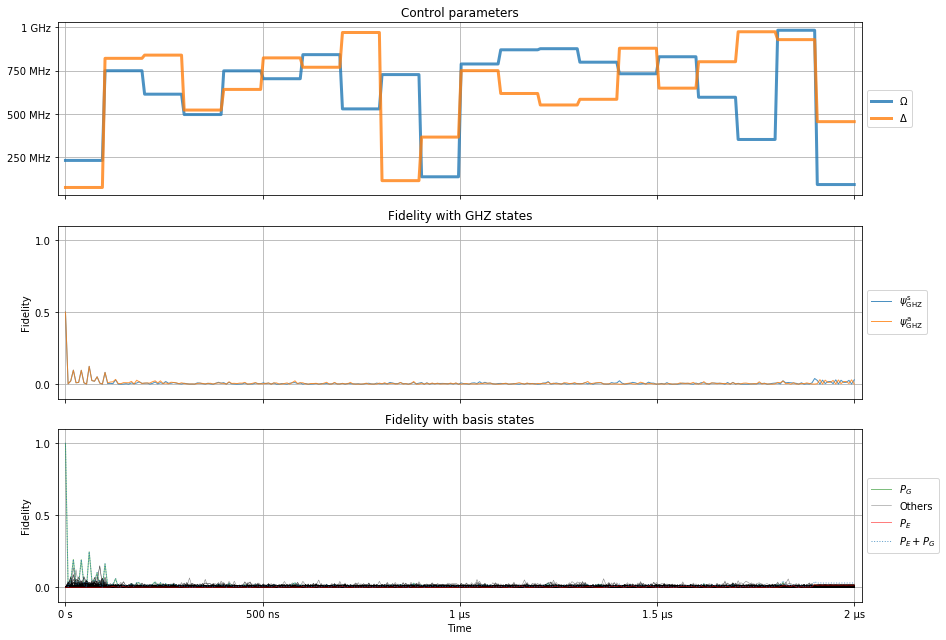

In [7]:
N = 8
optim_result = get_optimised_controls(N, n_ts=20)
report_stats(optim_result, N)
plot_optimresult(optim_result, N, norm_t, characteristic_V, geometry=RegularLattice1D(LATTICE_SPACING))


------------------------------------
---- Control optimisation stats ----
**** Timings (HH:MM:SS.US) ****
Total wall time elapsed during optimisation: 0:00:15.446519
Wall time computing Hamiltonians: 0:00:01.383147 (8.95%)
Wall time computing propagators: 0:00:13.929366 (90.18%)
Wall time computing forward propagation: 0:00:00.023906 (0.15%)
Wall time computing onward propagation: 0:00:00.024810 (0.16%)
Wall time computing gradient: 0:00:00.060857 (0.39%)

**** Iterations and function calls ****
Number of iterations: 17
Number of fidelity function calls: 33
Number of times fidelity is computed: 32
Number of gradient function calls: 33
Number of times gradients are computed: 32
Number of times timeslot evolution is recomputed: 32

**** Control amplitudes ****
Number of control amplitude updates: 31
Mean number of updates per iteration: 1.8235294117647058
Number of timeslot values changed: 310
Mean number of timeslot changes per update: 10.0
Number of amplitude values changed: 620
Mean 

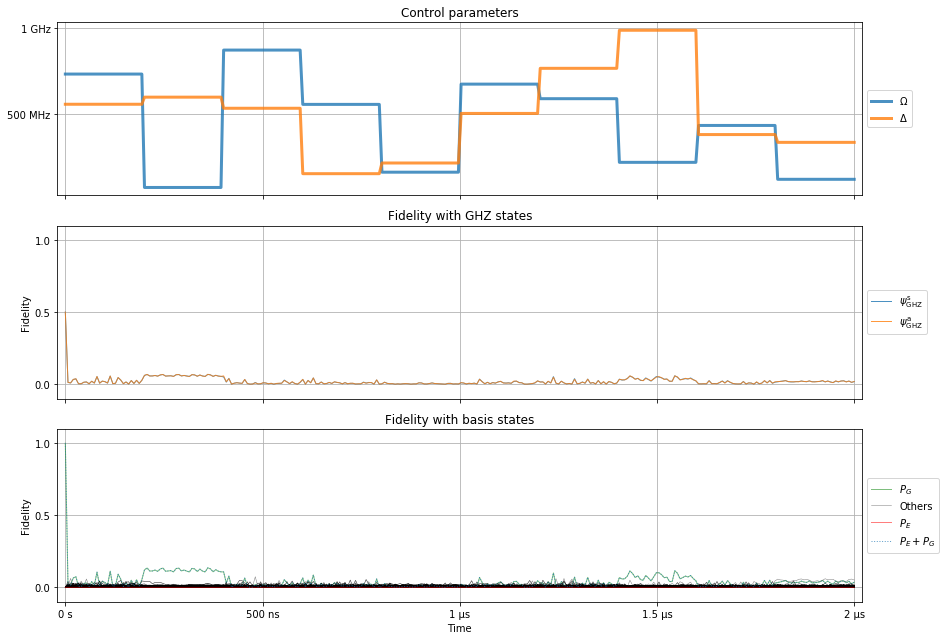

In [8]:
N = 8
optim_result = get_optimised_controls(N, n_ts=10)
report_stats(optim_result, N)
plot_optimresult(optim_result, N, norm_t, characteristic_V, geometry=RegularLattice2D((2, 4), LATTICE_SPACING))

In [ ]:
N = 8
optim_result = get_optimised_controls(N, n_ts=10)
report_stats(optim_result, N)
plot_optimresult(optim_result, N, norm_t, characteristic_V, geometry=RegularLattice3D((2, 2, 2), LATTICE_SPACING))